In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from utils import Lottery, plot_values, plot_action_probs


torch.manual_seed(12046)

In [2]:
def get_cum_rewards(r, gamma):
    cum_rewards = []
    last_cum_reward = 0
    for j in reversed(r):
        last_cum_reward = j + gamma * last_cum_reward
        cum_rewards.insert(0, last_cum_reward)
    return cum_rewards

get_cum_rewards(torch.normal(1, 0.01, (10,)), 0.9)

[tensor(6.5165),
 tensor(6.1287),
 tensor(5.7060),
 tensor(5.2304),
 tensor(4.7006),
 tensor(4.0907),
 tensor(3.4481),
 tensor(2.7195),
 tensor(1.9079),
 tensor(0.9982)]

In [3]:
gamma = 0.9
learning_rate = 0.01
grad_clip = 1.0
vf_weight = 0.1

In [4]:
class ActorNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.emb = nn.Embedding(2, 4)
        self.ln = nn.Linear(4, 2)

    def forward(self, x):
        # x: (G)
        x = F.relu(self.emb(x))
        x = self.ln(x)
        return x

class BaselineNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.emb = nn.Embedding(2, 4)
        self.ln = nn.Linear(4, 1)

    def forward(self, x):
        # x: (G)
        x = F.relu(self.emb(x))
        x = self.ln(x)
        return x

tokenizer = {'w': 0, 'l': 1}

In [5]:
@torch.no_grad()
def play_game(model, game):
    s = game.reset()
    done = False
    one_game_state = []
    one_game_reward = []
    one_game_action = []
    while not done:
        x = torch.tensor([tokenizer[s]])   # (1)
        logits = model(x)                  # (1, 2)
        probs = F.softmax(logits, dim=-1)  # (1, 2)
        action = torch.multinomial(probs, 1)
        next_s, r = game.step(action)
        one_game_action.append(action)
        one_game_state.append(s)
        one_game_reward.append(r)
        s = next_s
        if next_s == 't':
            done = True
    return one_game_state, one_game_action, one_game_reward

In [6]:
actor = ActorNet()
baseline = BaselineNet()
game = Lottery()
play_game(actor, game)

(['l', 'l'], [tensor([[1]]), tensor([[0]])], [-0.36660847067832947, 0])

In [7]:
# Baseline
actor = ActorNet()
baseline = BaselineNet()
actor_optimizer = optim.AdamW(actor.parameters(), lr=learning_rate)
baseline_optimizer = optim.AdamW(baseline.parameters(), lr=learning_rate)
actor_re = []
baseline_re = []

for t in range(1000):
    states, actions, rewards = play_game(actor, game)
    # 将一次游玩看成是G次游玩
    cum_rewards = get_cum_rewards(rewards, gamma)
    cum_rewards = torch.tensor(cum_rewards)                    # (G)
    states = torch.tensor([tokenizer[s] for s in states])      # (G)
    actions = torch.concat(actions).squeeze(-1)                # (G)
    # update baseline
    baseline_optimizer.zero_grad()
    with torch.no_grad():
        # baseline(states): (G, 1)
        advantage = cum_rewards - baseline(states).squeeze(-1)  # (G)
    baseline_loss = -advantage * baseline(states)               # (G)
    baseline_loss.mean().backward()
    baseline_optimizer.step()
    # update actor
    actor_optimizer.zero_grad()
    logits = actor(states)                                     # (G, 2)
    # ln(probability)
    lnP = -F.cross_entropy(logits, actions, reduction='none')  # (G)
    actor_loss = -advantage * lnP
    actor_loss.mean().backward()
    actor_optimizer.step()
    # record actor
    _a_re = {}
    _c_re = {}
    for k in tokenizer:
        inputs = torch.tensor([tokenizer[k]])
        _re = F.softmax(actor(inputs), dim=-1)  # (1, 2)
        _a_re[k] = _re.squeeze(0).tolist()
        _c_re[k] = baseline(inputs).item()
    actor_re.append(_a_re)
    baseline_re.append(_c_re)

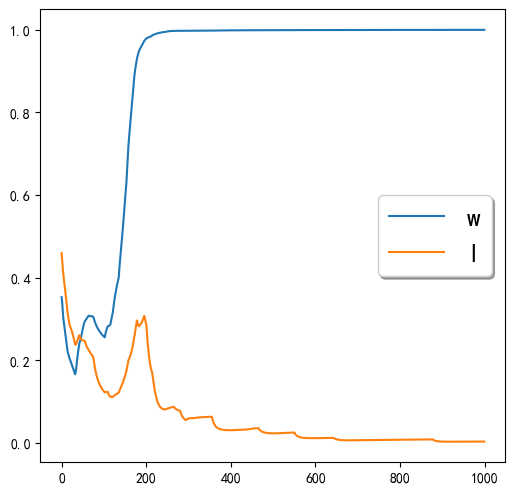

In [8]:
fig = plot_action_probs(actor_re)

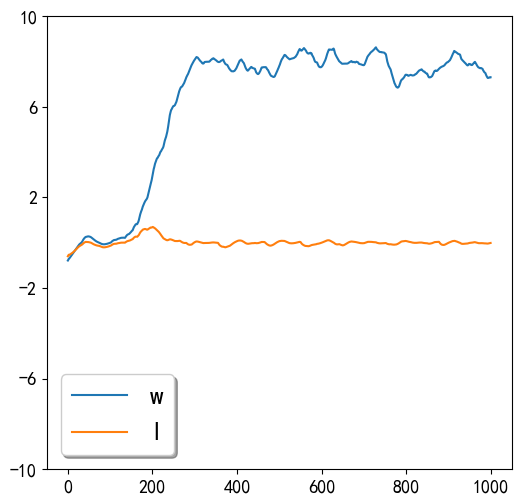

In [9]:
fig = plot_values(baseline_re)

In [10]:
class A2C(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.emb = nn.Embedding(2, 4)
        self.action_ln = nn.Linear(4, 2)
        self.critic_ln = nn.Linear(4, 1)

    def forward(self, x):
        # x: (G)
        x = F.relu(self.emb(x))
        actions = self.action_ln(x)
        values = self.critic_ln(x)
        return actions, values

In [11]:
model = A2C()
x = torch.randint(2, (10,))
logits, values = model(x)
logits.shape, values.shape

(torch.Size([10, 2]), torch.Size([10, 1]))

In [12]:
model = A2C()
actor = lambda x: model(x)[0]
game = Lottery()
play_game(actor, game)

(['w'], [tensor([[0]])], [0])

In [13]:
# One-step actor-critic
model = A2C()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
actor_re = []
critic_re = []

for t in range(2000):
    actor = lambda x: model(x)[0]
    # 可以不用游戏结束就可以训练
    states, actions, rewards = play_game(actor, game)
    states = torch.tensor([tokenizer[s] for s in states])      # (G)
    rewards = torch.tensor(rewards)                            # (G)
    actions = torch.concat(actions).squeeze(-1)                # (G)
    optimizer.zero_grad()
    with torch.no_grad():
        _, values = model(states)                                # (G, 1)
        values = values.squeeze(1)                               # (G)   
        vt_next = torch.cat((values[:-1], torch.tensor([0.0])))  # (G)
        advantage = rewards + gamma * vt_next - values           # (G)
    logits, vt = model(states)
    vt = vt.squeeze(1)                                           # (G)
    lnP = -F.cross_entropy(logits, actions, reduction='none')    # (G)
    vf_loss = -advantage * vt
    pg_loss = -advantage * lnP
    loss = vf_weight * vf_loss.mean() + pg_loss.mean()
    loss.backward()
    optimizer.step()
    # record actor
    _a_re = {}
    _c_re = {}
    for k in tokenizer:
        inputs = torch.tensor([tokenizer[k]])
        logits, v = model(inputs)
        _re = F.softmax(logits, dim=-1)  # (1, 2)
        _a_re[k] = _re.squeeze(0).tolist()
        _c_re[k] = v.item()
    actor_re.append(_a_re)
    critic_re.append(_c_re)

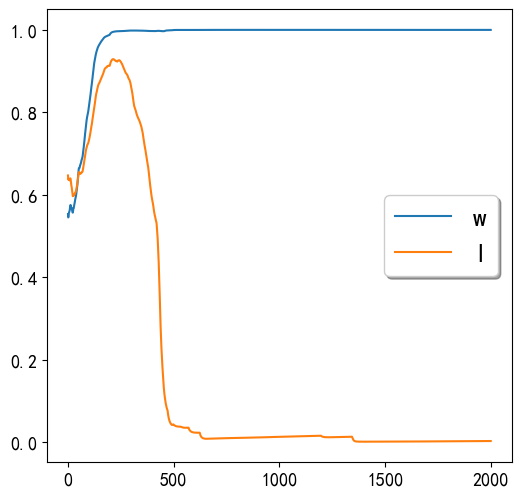

In [14]:
fig = plot_action_probs(actor_re)

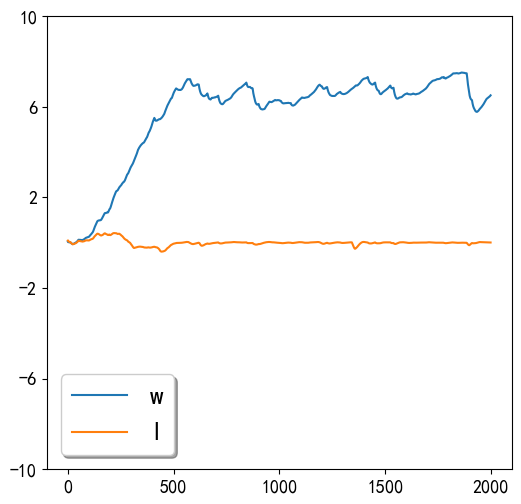

In [15]:
fig = plot_values(critic_re)